<h1>Pratical Assignment 2</h1>
<h5>António Cardoso & Tomás Azevedo</h5>
This jupyter notebook holds the python code for the Pratical Assignment 2 sent with the Final Presentation PDF.

Here we have all the code that generates the ML Models and their evaluation/comparison graphs.

<h3>Global Libraries</h3>

In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt

<h3>Data Cleaning and Tidying</h3>

In [3]:
#open csv
games = pd.read_csv("video_games.csv")
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5824 non-null   int64  
 1   name            5824 non-null   object 
 2   category        5824 non-null   object 
 3   n_dlcs          5824 non-null   int64  
 4   n_expansions    5824 non-null   int64  
 5   year            5824 non-null   int64  
 6   follows         5824 non-null   int64  
 7   in_franchise    5824 non-null   bool   
 8   genres          5803 non-null   object 
 9   companies       5781 non-null   object 
 10  platforms       5824 non-null   object 
 11  user_score      5824 non-null   float64
 12  user_rating     5824 non-null   object 
 13  n_user_reviews  5824 non-null   int64  
 14  summary         5816 non-null   object 
dtypes: bool(1), float64(1), int64(6), object(7)
memory usage: 642.8+ KB


There are some naturally unrelated attributes to user_rating. Let's drop those columns.

In [4]:
games = games.drop(columns=["companies","id","summary","name","category"])

From game.info(), now without the attributes dropped, we have some null values in the "games" column. We will be dropping those rows.

In [5]:
games = games.dropna(subset=["genres"])

Let's verify that there are no more null values.

In [6]:
games.isnull().any()

n_dlcs            False
n_expansions      False
year              False
follows           False
in_franchise      False
genres            False
platforms         False
user_score        False
user_rating       False
n_user_reviews    False
dtype: bool

Before enconding categorical variables, let's see the distribution of the labels in the column of user_rating.

In [7]:
games.user_rating.value_counts()

great       3185
good        2509
mediocre      97
bad           12
Name: user_rating, dtype: int64

From here we can see that the distribution won't be very helpful when training the ML models, since "bad" and "mediocre" only take around 2% of all labels.

Time to encode the non-numerical variables! For this task we will be using sklearn's LabelEncoder.

For user_rating and in_franchise we will be encoding them normally.
For platforms and genres we will be substituting every element by the amount of platforms support and amount of genres categorized, respectively.

In [8]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

games.user_rating = enc.fit_transform(games.user_rating)
games.in_franchise = enc.fit_transform(games.in_franchise)

num_plats = [len(plats.split(", ")) for plats in games.platforms]
games.platforms = num_plats

num_genres = [len(genre.split(", ")) for genre in games.genres]
games.genres = num_genres

Let's display the correlation matrix in a heatmap to checkout which attributes are the most suitable to train or models on. Only values greater than 0.1 will be displayed.

<AxesSubplot:>

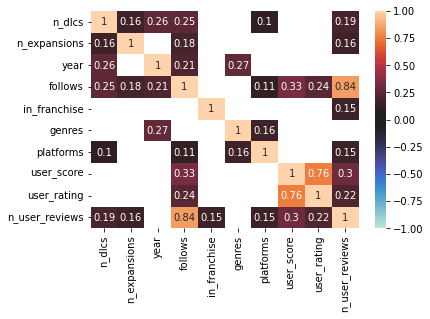

In [9]:
correlationMatrix = games.corr(method="spearman")
sns.heatmap(correlationMatrix[correlationMatrix > 0.1], annot=True, vmin=-1, vmax=1, center=0)

With the heatmap we can conclude that there are not many attributes that have a good correlation with user_score and user_rating.

<h3>Building and Optimizing the Models</h3>

From the previous correlation matrix, we've decided that the attributes to base our models on will be "n_dlcs", "follows", "in_franchise" and "n_user_reviews".

And, obviously, they will try to predict "user_rating".

Let's split the data!

In [10]:
from sklearn.model_selection import train_test_split

x = games[["n_dlcs","follows","in_franchise","n_user_reviews"]]
y = games[["user_rating"]]

seed = 200 #random number

<h4>Decision Tree Classifier</h4>

We will be building various DT models to later select the optimal one.

Our experiment will be based on varying the size of the training set and the maximum number of nodes the DT can have, saving the best values for Accuracy, Precision, Recall and F1 Score.

For this task we will be using sklearn's DecisionTreeClassifier to build every DT model, and the funcition of accuracy_score, precision_socre, recall_score and f1_score to calculate the metrics of each model.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

bestAcc = [0,0,0,0,0,0]
bestPrec = [0,0,0,0,0,0]
bestRecall = [0,0,0,0,0,0]
bestF1 = [0,0,0,0,0,0]

j = 0.2
while j <= 0.8:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=j, random_state=seed, stratify=y)

    for i in range(3,100):
        dt = DecisionTreeClassifier(random_state=0, max_leaf_nodes=i, criterion="entropy")
        dt.fit(x_train, y_train.values.ravel())

        y_true = y_test
        y_pred = dt.predict(x_test)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="weighted",zero_division=0)
        recall = recall_score(y_true, y_pred, average="weighted")
        f1 = f1_score(y_true, y_pred, average="weighted")

        if accuracy > bestAcc[2]:
            bestAcc = [i,j,accuracy,precision,recall,f1]
        if precision > bestPrec[3]:
            bestPrec = [i,j,accuracy,precision,recall,f1]
        if recall > bestRecall[4]:
            bestRecall = [i,j,accuracy,precision,recall,f1]
        if f1 > bestF1[5]:
            bestF1 = [i,j,accuracy,precision,recall,f1]
    j += 0.05

    metricsTableDT = pd.DataFrame([bestAcc,bestPrec,bestRecall,bestF1],
                                index=["bestAcc","bestPrec","bestRecall","bestF1"],
                                columns=["max_leaf_nodes","test_size","accuracy","precision","recall","f1"])

metricsTableDT

,max_leaf_nodes,test_size,accuracy,precision,recall,f1
bestAcc,17,0.2,0.631352,0.614844,0.631352,0.618938
bestPrec,3,0.2,0.609819,0.625881,0.609819,0.602281
bestRecall,17,0.2,0.631352,0.614844,0.631352,0.618938
bestF1,17,0.2,0.631352,0.614844,0.631352,0.618938


From the table displayed, we can assure that our optimal DT model is for a training size of 0.8 and 17 max_leaf_nodes.

Just for a quick visualization, let's print our model.

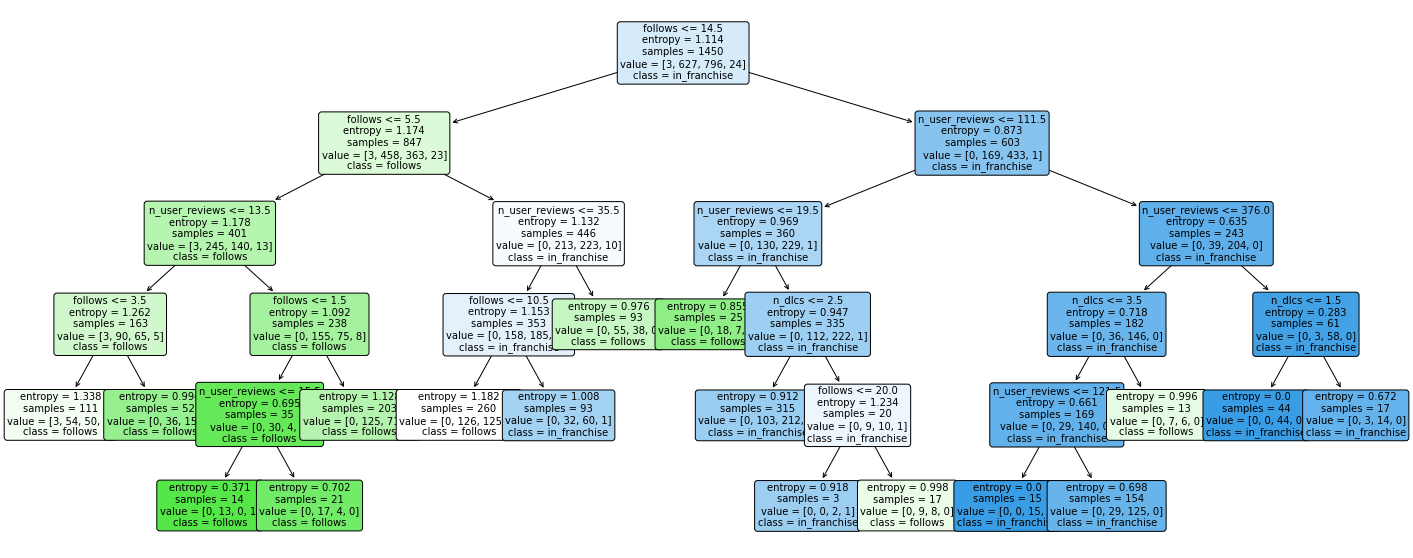

In [12]:
dt = DecisionTreeClassifier(random_state=0, max_leaf_nodes=17, criterion="entropy")
dt.fit(x_train, y_train)
dt.score(x_test, y_test)

from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10)) 
a = tree.plot_tree(dt, rounded = True,filled = True,fontsize=10, class_names=["n_dlcs","follows","in_franchise","n_user_reviews"], feature_names=["n_dlcs","follows","in_franchise","n_user_reviews"]) 
plt.show()

One last note we can take from this print, is that our DT model can't classify any input data as a "bad" or "mediocre" game, which is not a good thing. 

<h4>K-Nearest Neighbors Classifier</h4>

We will be building various KNN models to later select the optimal one, just like before with the DT ones.

Our experiment will be based on varying the some parameters of the KNN model (n_neighbors, algorithm and metric), saving the best values for Accuracy, Precision, Recall and F1 Score.

For this task we will be using sklearn's KNeighborsClassifier to build every KNN model and the previous evaluation funtions.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

bestAcc = [0,0,0,0,0,0,0]
bestPrec = [0,0,0,0,0,0,0]
bestRecall = [0,0,0,0,0,0,0]
bestF1 = [0,0,0,0,0,0,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y)

for i in range(2,100): 
    for j in ['ball_tree', 'kd_tree', 'brute', 'auto']:
        for l in ['minkowski', 'euclidean', 'manhattan', 'chebyshev']:
            knn = KNeighborsClassifier(n_neighbors=i,algorithm=j,metric=l)
            knn.fit(x_train, y_train.values.ravel())

            y_true = y_test
            y_pred = knn.predict(x_test)

            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average="weighted",zero_division=0)
            recall = recall_score(y_true, y_pred, average="weighted")
            f1 = f1_score(y_true, y_pred, average="weighted")

            if accuracy > bestAcc[3]:
                bestAcc = [i,j,l,accuracy,precision,recall,f1]
            if precision > bestPrec[4]:
                bestPrec = [i,j,l,accuracy,precision,recall,f1]
            if recall > bestRecall[5]:
                bestRecall = [i,j,l,accuracy,precision,recall,f1]
            if f1 > bestF1[6]:
                bestF1 = [i,j,l,accuracy,precision,recall,f1]

metricsTableKNN = pd.DataFrame([bestAcc,bestPrec,bestRecall,bestF1],
                            index=["bestAcc","bestPrec","bestRecall","bestF1"],
                            columns=["n_neighbors","knn_algorithm","knn_metric","accuracy","precision","recall","f1"])

metricsTableKNN

,n_neighbors,knn_algorithm,knn_metric,accuracy,precision,recall,f1
bestAcc,68,kd_tree,manhattan,0.645134,0.629652,0.645134,0.635295
bestPrec,68,kd_tree,manhattan,0.645134,0.629652,0.645134,0.635295
bestRecall,68,kd_tree,manhattan,0.645134,0.629652,0.645134,0.635295
bestF1,68,kd_tree,manhattan,0.645134,0.629652,0.645134,0.635295


From the resulting table, we can see that the KNN model with n_neighbors=68, algorithm="kd_tree" and metric="manhattan" is the best model for all evaluation metrics, therefore being our optimal model.

Let's print the decision regions of our KNN.

C:\Users\anton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\mlxtend\plotting\decision_regions.py:300: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<AxesSubplot:>

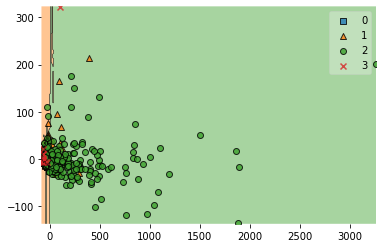

In [14]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
knn = KNeighborsClassifier(n_neighbors=68,algorithm="kd_tree",metric="manhattan")
# Plotting decision region
pca = PCA(n_components = 2)
x_train2 = pca.fit_transform(x_train)
knn.fit(x_train2, y_train.values.ravel())
x_test2=pca.fit_transform(x_test)
plot_decision_regions(x_test2, y_test.values.ravel(), clf=knn)

<h3>Comparison between optimal models and a Dummy model</h3>

This comparison will be performed to watch how our optimal models behave against a control model, which will be a sklearn's DummyClassifier.

In [15]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="stratified",random_state=seed) #using "most_frequent" because it's the most accurate and the the most frequent label occupies ~55% of all labeling
dt.fit(x_train, y_train)
knn.fit(x_train, y_train.values.ravel())
dummy.fit(x_train, y_train)

y_true = y_test
y_pred_DT = dt.predict(x_test)
y_pred_KNN = knn.predict(x_test)
y_pred_Dummy = dummy.predict(x_test)

valuesDT = [accuracy_score(y_true, y_pred_DT), precision_score(y_true, y_pred_DT, average="weighted", zero_division=0), recall_score(y_true, y_pred_DT, average="weighted"), f1_score(y_true, y_pred_DT, average="weighted")]

valuesKNN = [accuracy_score(y_true, y_pred_KNN), precision_score(y_true, y_pred_KNN, average="weighted", zero_division=0), recall_score(y_true, y_pred_KNN, average="weighted"), f1_score(y_true, y_pred_KNN, average="weighted")]

valuesDummy = [accuracy_score(y_true, y_pred_Dummy), precision_score(y_true, y_pred_Dummy, average="weighted", zero_division=0), recall_score(y_true, y_pred_Dummy, average="weighted"), f1_score(y_true, y_pred_Dummy, average="weighted")]


metricsTableComparision = pd.DataFrame([valuesDummy, valuesDT, valuesKNN],
                            index=["Dummy Model","Best DT","Best KNN"],
                            columns=["Accuracy","Precision","Recall","F1 Score"])

metricsTableComparision

,Accuracy,Precision,Recall,F1 Score
Dummy Model,0.491817,0.490164,0.491817,0.490967
Best DT,0.631352,0.614844,0.631352,0.618938
Best KNN,0.645134,0.629652,0.645134,0.635295


We can see that our Decision Tree and KNN model outperform the Dummy model by ~14% in all values of Accuracy, Precision, Recall and F1 Score.

These differences indicate us that both models are slightly better than a random classifier.

<h3>Evaluation and Comparison between Both Models</h3>

<h4>Training and Testing Error</h4>

Let's see how does the training and testing error change with variation of leaf nodes on the tree.

Text(0.5, 1.0, 'Training and Testing Error Under Varying N Leaf Nodes')

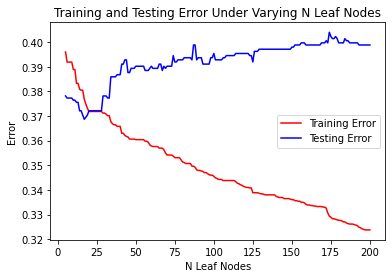

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y)

train_scores=[]
test_scores=[]
nleaves=list(range(5,201)) 

for k in nleaves:
    dt.max_leaf_nodes=k 
    dt.fit(x_train,y_train)
    train_score=dt.score(x_train,y_train)
    test_score=dt.score(x_test,y_test)
    train_scores.append(1-train_score)
    test_scores.append(1-test_score)

plt.plot(nleaves,train_scores, color='red',label='Training Error')
plt.plot(nleaves,test_scores, color='blue',label='Testing Error')
plt.legend(loc='center right')
plt.xlabel('N Leaf Nodes')
plt.ylabel('Error')
plt.title('Training and Testing Error Under Varying N Leaf Nodes')

As we can see, the Decision Tree model from 30 leaf nodes up has a high variance increase rate, which means it is prone to overfit around the data with a larger number of leaf nodes.

Now, let's watch how's the training/testing error in KNN.

Text(0.5, 1.0, 'Training and Testing Error Under Varying K Values')

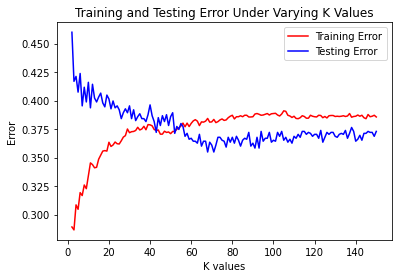

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y)

train_scores=[]
test_scores=[]
k_values=list(range(2,151))

for k in k_values: 
    knn.n_neighbors=k 
    knn.fit(x_train,y_train.values.ravel())
    train_score=knn.score(x_train,y_train)
    test_score=knn.score(x_test,y_test)
    train_scores.append(1-train_score)
    test_scores.append(1-test_score)

plt.plot(k_values,train_scores, color='red',label='Training Error')
plt.plot(k_values,test_scores, color='blue',label='Testing Error')
plt.legend(loc='upper right')
plt.xlabel('K values')
plt.ylabel('Error')
plt.title('Training and Testing Error Under Varying K Values')

The values of testing and training error coverge and have little variance, which leads us to belive that our KNN is not overfitted.

From this graph we can also check that our result for the optimal n_neighbors value is indeed 68, since it's the value which yields the lowest testing error.

<h4>Learning Curves</h4>

Studying the Learning Curve for both models helps us to see how accuracy changes with varying sample size.

Text(0, 0.5, 'Accuracy')

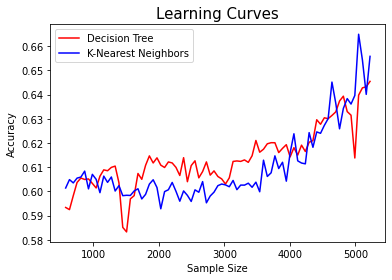

In [18]:
training_sample_size = []
accuracy_per_size_DT = []
accuracy_per_size_KNN = []

i = 0.9
while i >= 0.1:
    i = round(i, 2)
    sample_size = round(len(x)*(1-i))
    training_sample_size.append(sample_size)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=i, random_state=seed, stratify=y)

    # Decision Tree
    dt = DecisionTreeClassifier(random_state=0, max_leaf_nodes=17, criterion="entropy")
    dt.fit(x_train, y_train)
    accuracy_per_size_DT.append(dt.score(x_test,y_test))

    # KNN
    knn = KNeighborsClassifier(n_neighbors=68,algorithm="kd_tree",metric="manhattan")
    knn.fit(x_train, y_train.values.ravel())
    accuracy_per_size_KNN.append(knn.score(x_test,y_test))

    i -= 0.01

# graph of accuracy in relation to size of training set
plt.plot(training_sample_size, accuracy_per_size_DT, color='red',label='Decision Tree')
plt.plot(training_sample_size, accuracy_per_size_KNN, color='blue',label='K-Nearest Neighbors')
plt.legend(loc='upper left')
plt.title("Learning Curves", size=15)
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")


We can conclude that both models have similar learning curves.

However, the rate of change in accuracy per sample size is very small: in both DT and KNN, accuracy only increases ~6% with more 4000 samples to train the models on.

Thus, giving more data propbably wouldn't improve the model much more.

<h4>ROC - Receiver Operating Characteristics</h4>

The ROC gives us the connection between the True Positive Rate (TPR) in relation to the False Positive Rate (FPR), which can help us determine if a classifier is good – High TPR & Low FPR – or if a classifier is bad – Low TPR & High FPR.

To display the ROC graphics, we're gonna use the Yellowbrick library, which will help us draw a ROC graph each label.

Let's check the ROCs for the DT

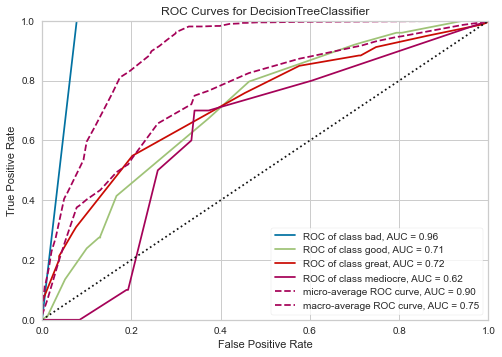

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [19]:
from yellowbrick.classifier import ROCAUC

dt = DecisionTreeClassifier(random_state=0, max_leaf_nodes=17, criterion="entropy")
visualizerDT = ROCAUC(dt, encoder={0: "bad", 1: "good", 2: "great", 3: "mediocre"})
visualizerDT.fit(x_train, y_train)
visualizerDT.score(x_test, y_test)
visualizerDT.show()

All ROCs of the DT model show that its TPR has an acceptable relation to FPR, since the curve are relatively close to the diagonal line.

From this we could characterize the DT model as mediocre.

Now, let's check the ROCs for the KNN.

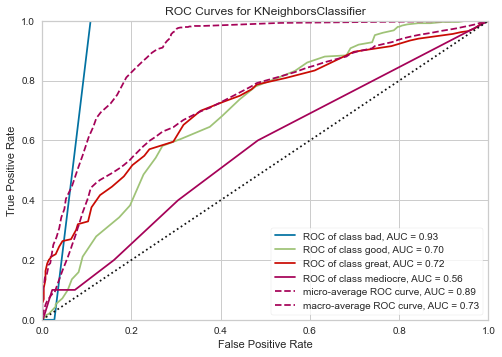

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [20]:
knn = KNeighborsClassifier(n_neighbors=68,algorithm="kd_tree",metric="manhattan")
visualizerKNN = ROCAUC(knn, encoder={0: "bad", 1: "good", 2: "great", 3: "mediocre"})
visualizerKNN.fit(x_train, y_train.values.ravel())
visualizerKNN.score(x_test, y_test)
visualizerKNN.show()

Just like the DT’s ROCs, KNN has a slightly good TPR to FPR relation, although for lower FPR has worse TPR in comparison to DT’s.
